In [1]:
!pip install pydicom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 24.8 MB/s eta 0:00:00


In [2]:
from google.colab import files, drive
import os
import shutil
import zipfile
import pandas as pd
import numpy as np
import pydicom
from pathlib import Path
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.keras.layers import Layer, Convolution2D, Dense, RandomRotation, RandomFlip, Resizing, Rescaling
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Input, ReLU, AveragePooling2D, Activation, Flatten
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras import losses, optimizers
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [3]:
# Upload kaggle.json file
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Create Kaggle directory
os.makedirs("/root/.kaggle", exist_ok=True)

# Move kaggle.json to the correct location
shutil.move("kaggle.json", "/root/.kaggle/kaggle.json")

# Set file permissions
os.chmod("/root/.kaggle/kaggle.json", 600)

In [6]:
!kaggle competitions download -c rsna-pneumonia-detection-challenge -p /content/rsna_data

100% 3.65G/3.66G [00:26<00:00, 108MB/s]
100% 3.66G/3.66G [00:26<00:00, 146MB/s]


In [7]:
# Unzip the dataset
zip_path = "/content/rsna_data/rsna-pneumonia-detection-challenge.zip"
extract_path = "/content/rsna_data/"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [8]:
# Set dataset path
rsna_dataset_input_path = "/content/rsna_data"

train_class = pd.read_csv(os.path.join(rsna_dataset_input_path, 'stage_2_detailed_class_info.csv'))
train_labels = pd.read_csv(os.path.join(rsna_dataset_input_path, 'stage_2_train_labels.csv'))

train_path = Path(os.path.join(rsna_dataset_input_path, 'stage_2_train_images'))
test_path = Path(os.path.join(rsna_dataset_input_path, 'stage_2_test_images'))

train_meta = pd.concat([train_labels, train_class.drop(columns=['patientId'])], axis=1)

In [9]:
def save_img_from_dcm(dcm_dir, img_dir, patient_id):
    img_fp = os.path.join(img_dir, "{}.jpg".format(patient_id))
    if os.path.exists(img_fp):
        return
    dcm_fp = os.path.join(dcm_dir, "{}.dcm".format(patient_id))
    img_1ch = pydicom.dcmread(dcm_fp).pixel_array
    img_3ch = np.stack([img_1ch]*3, -1)

    img_fp = os.path.join(img_dir, "{}.jpg".format(patient_id))
    cv2.imwrite(img_fp, img_3ch)

In [10]:
%%time

def get_image(dcm_file):
    ADJUSTED_IMAGE_SIZE = 128
    dcm_data = pydicom.dcmread(dcm_file)
    img = dcm_data.pixel_array
    img = np.stack((img,) * 3, -1)

    img = np.array(img).astype(np.uint8)
    res = cv2.resize(img,(ADJUSTED_IMAGE_SIZE,ADJUSTED_IMAGE_SIZE), interpolation = cv2.INTER_LINEAR)
    return res

def read_train(rowData):
    imageList = []
    for index, row in tqdm(rowData.iterrows()):
        patientId = row.patientId
        dcm_file = '/content/rsna_data/stage_2_train_images/'+'{}.dcm'.format(patientId)
        imageList.append(get_image(dcm_file))

    return np.array(imageList)

def read_test(path):
    imageList = []
    for file_name in tqdm(os.listdir(path)):
        dcm_file = dcm_file = os.sep.join([path, file_name])
        imageList.append(get_image(dcm_file))
    return np.array(imageList)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.11 µs


In [11]:
test_images_path = '/content/rsna_data/stage_2_test_images'
test_images = read_test(test_images_path)

train_images = read_train(train_labels)
print(train_images.shape)

100%|██████████| 3000/3000 [00:39<00:00, 76.31it/s]
30227it [04:09, 121.33it/s]


(30227, 128, 128, 3)


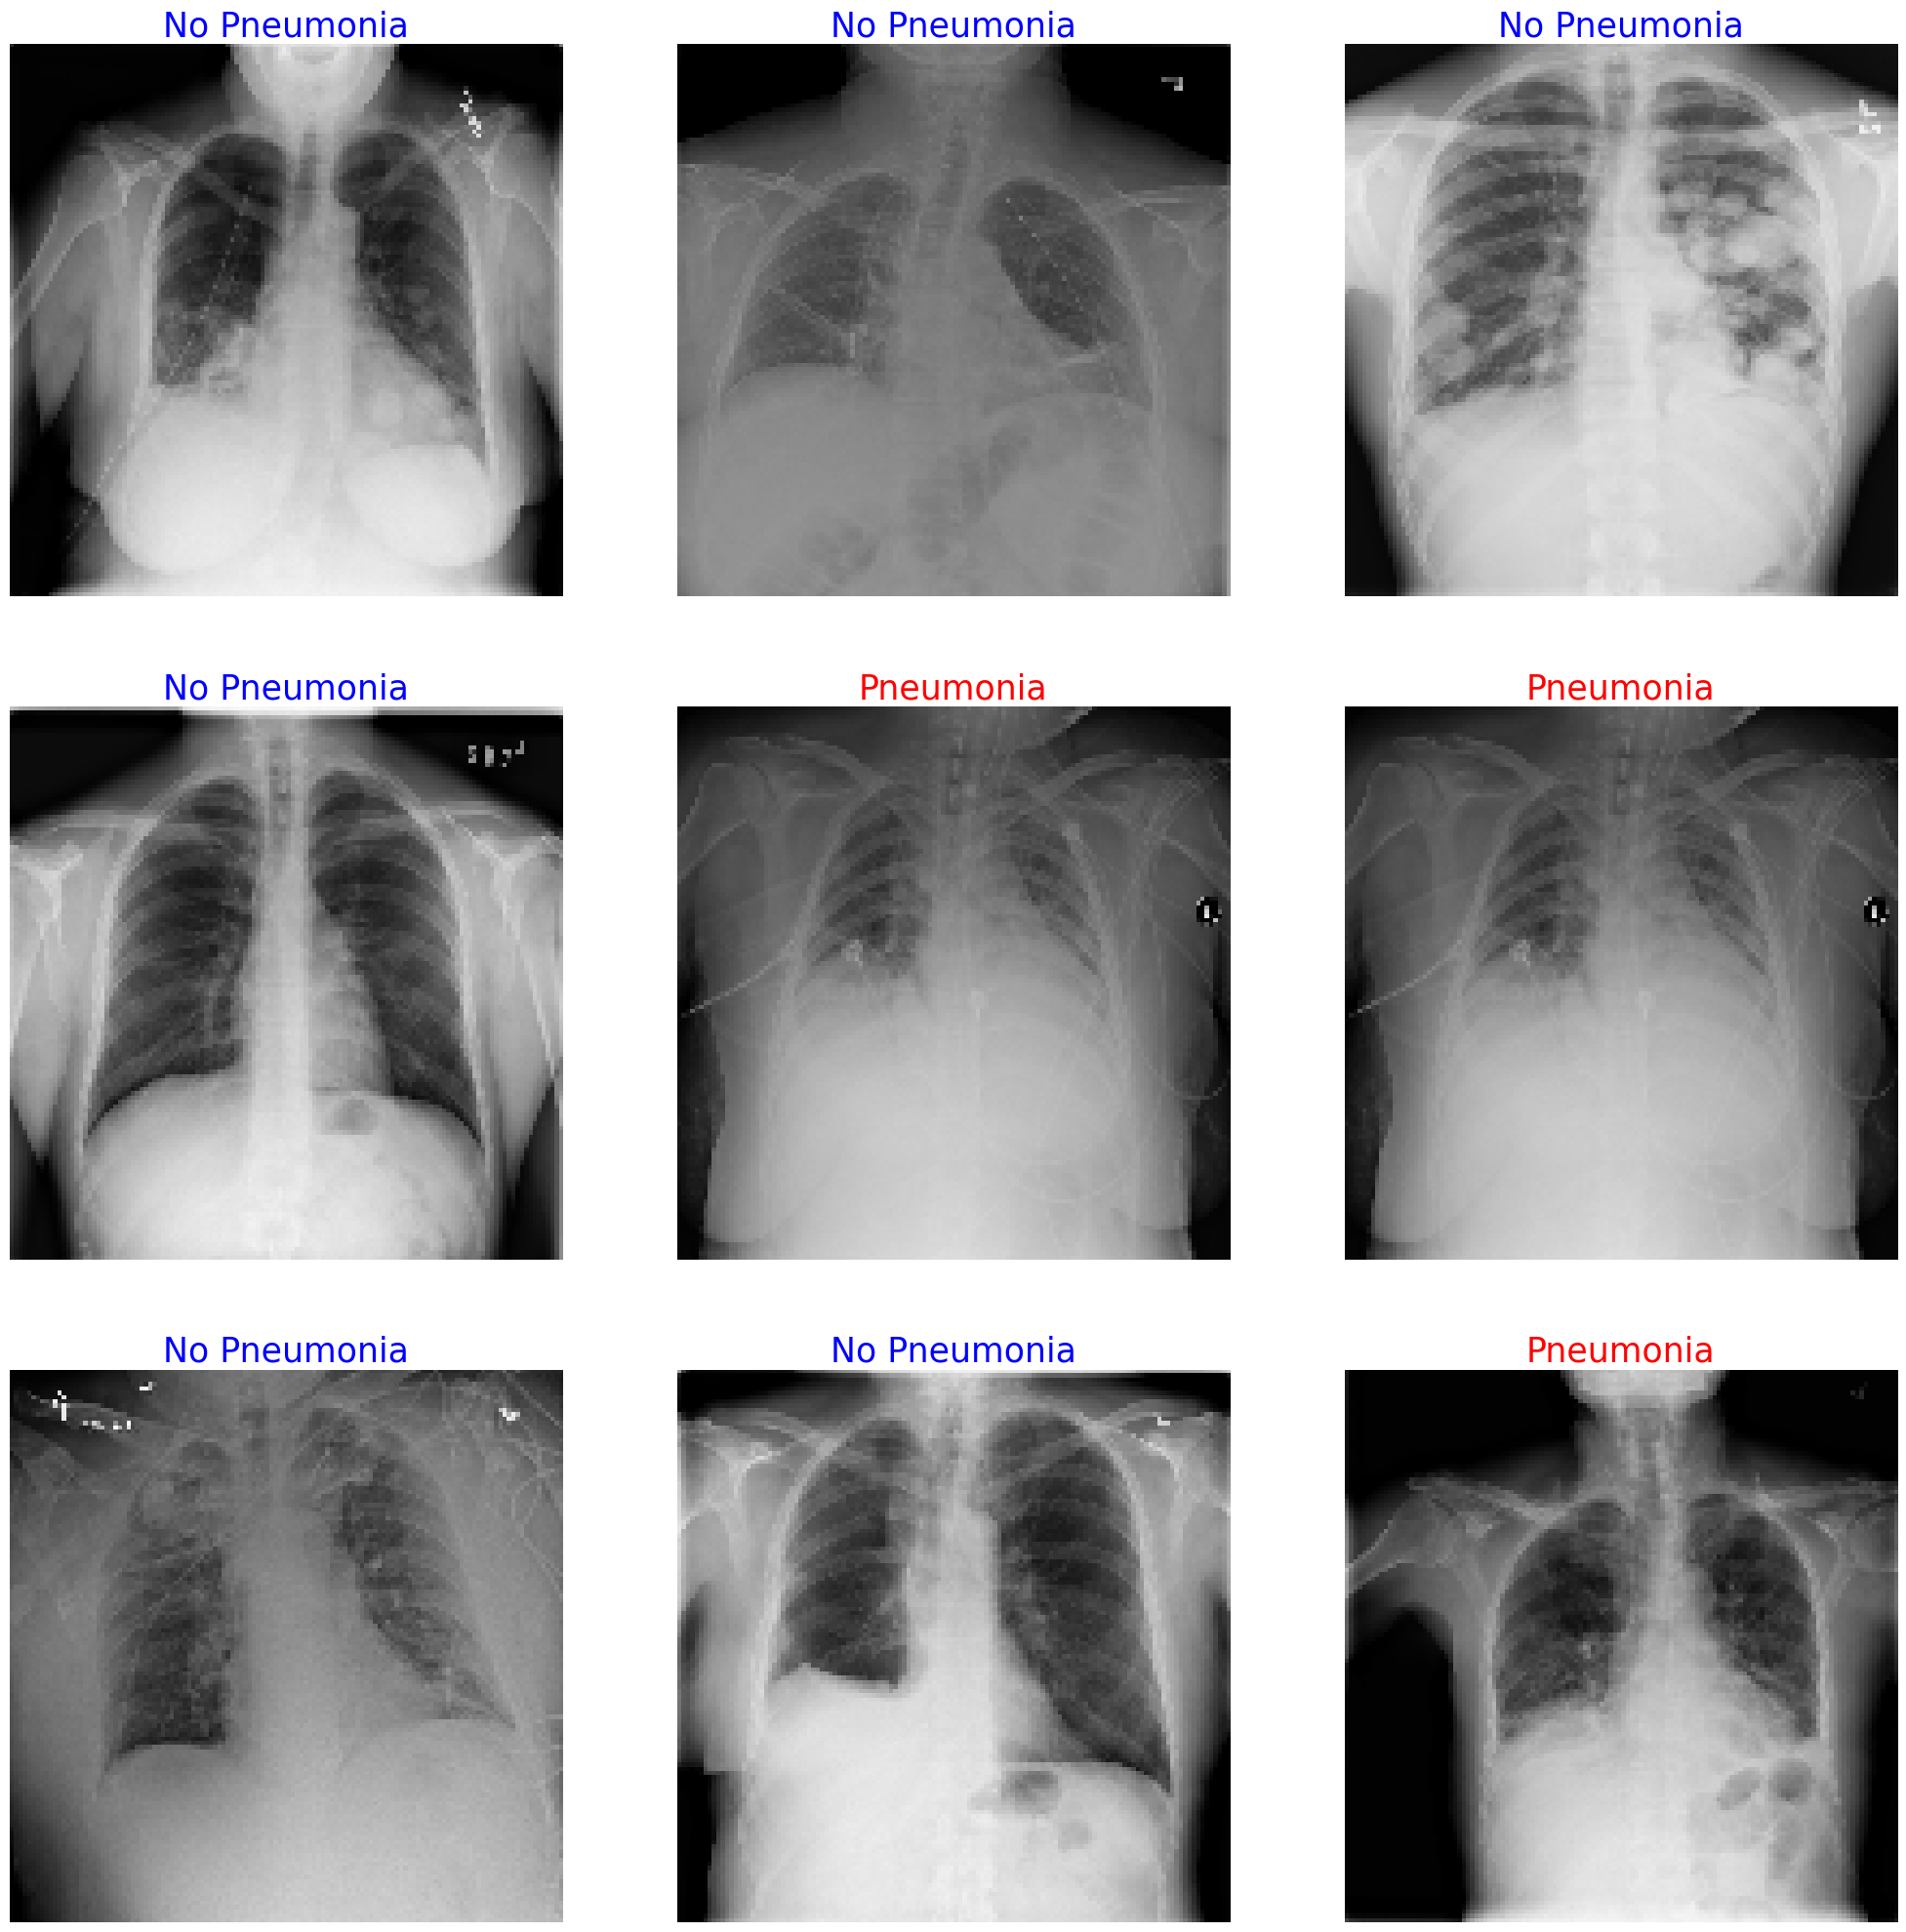

In [ ]:
plt.figure(figsize=(25,25)) #
for i, image in enumerate(train_images[:9]):

    plt.subplot(3,3,i+1)
    plt.imshow(image)
    if train_labels.loc[i]["Target"]:
        plt.title("Pneumonia", color="red", fontsize=25)
    else:
        plt.title("No Pneumonia", color="blue", fontsize=25)
    plt.axis('off')
plt.show()

In [17]:
y = pd.get_dummies(train_labels["Target"]).values
random_state = 42

X_train, X_test, y_train, y_test = train_test_split(train_images, y, test_size=0.2, random_state=random_state)

In [12]:
# Recall metric
def recall_m(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')

    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

# Precision metric
def precision_m(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')

    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

# F1 Score metric
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

In [ ]:
ADJUSTED_IMAGE_SIZE = 128
input_shape = (ADJUSTED_IMAGE_SIZE, ADJUSTED_IMAGE_SIZE, 3)
num_classes = y_train.shape[1]

In [ ]:
base_model = tf.keras.applications.ResNet50V2(weights='imagenet', include_top=False)

for layer in base_model.layers:
      layer.trainable = False

# Data Augmentation Step
augment = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.15)
], name='AugmentationLayer')

inputs = Input(shape = input_shape, name='inputLayer')
x = augment(inputs)
pretrain_out = base_model(x, training = False)
x = Flatten()(pretrain_out)
x = Dense(64, activation='relu')(x)
x = Dense(y_train.shape[1], name='outputLayer')(x)
outputs = Activation(activation="softmax", dtype=tf.float32, name='activationLayer')(x)
model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=AdamW(learning_rate=0.0005), #
                   loss=losses.categorical_crossentropy,
                   metrics=['accuracy', f1_m])

history = model.fit(X_train,
                         y_train,
                         batch_size=16,
                         epochs=100,
                         validation_data=(X_test, y_test),
                         callbacks=[
                             EarlyStopping(monitor = "val_loss", patience = 15,
                                           restore_best_weights = True, mode='min'),
                             ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min')
                    ]
                        )


fcl_loss, fcl_accuracy, fcl_f1  = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', fcl_loss)
print('Test accuracy:', fcl_accuracy)
print('Test F1:', fcl_f1)


df = pd.DataFrame({"pred": np.argmax(model.predict(X_test), axis=1), "true": np.argmax(y_test, axis=1)})
print(classification_report(df["true"], df["pred"]))

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/100
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 33s 15ms/step - accuracy: 0.6811 - f1_m: 0.6811 - loss: 40.5741 - val_accuracy: 0.7569 - val_f1_m: 0.7568 - val_loss: 12.8305 - learning_rate: 5.0000e-04
Epoch 2/100
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.7007 - f1_m: 0.7007 - loss: 16.4054 - val_accuracy: 0.7147 - val_f1_m: 0.7146 - val_loss: 7.9535 - learning_rate: 5.0000e-04
Epoch 3/100
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.7104 - f1_m: 0.7104 - loss: 2.7387 - val_accuracy: 0.6879 - val_f1_m: 0.6878 - val_loss: 1.2961 - learning_rate: 5.0000e-04
Epoch 4/100
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.7480 - f1_m: 0.7480 - loss: 0.5933 - val_accuracy: 0.7703 - val_f1_m: 0.7702 - val_loss: 0.4747 - learning_rate: 5.0000e-04
Epoch 5/100
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.7700 - f1_m: 0.7700 - loss: 0.4778 - val_accuracy: 0.7544 - val_f1_m: 0.7543 - val_loss: 0.4887

In [ ]:
drive_folder = "/content/drive/MyDrive/ResNet_rsna"
os.makedirs(drive_folder, exist_ok=True)

model_path = "/content/resnet_pneumonia.h5"
drive_path = os.path.join(drive_folder, "resnet_pneumonia.h5")

model.save(model_path)
shutil.copy(model_path, drive_path)

'/content/drive/MyDrive/ResNet_rsna/resnet_pneumonia.h5'

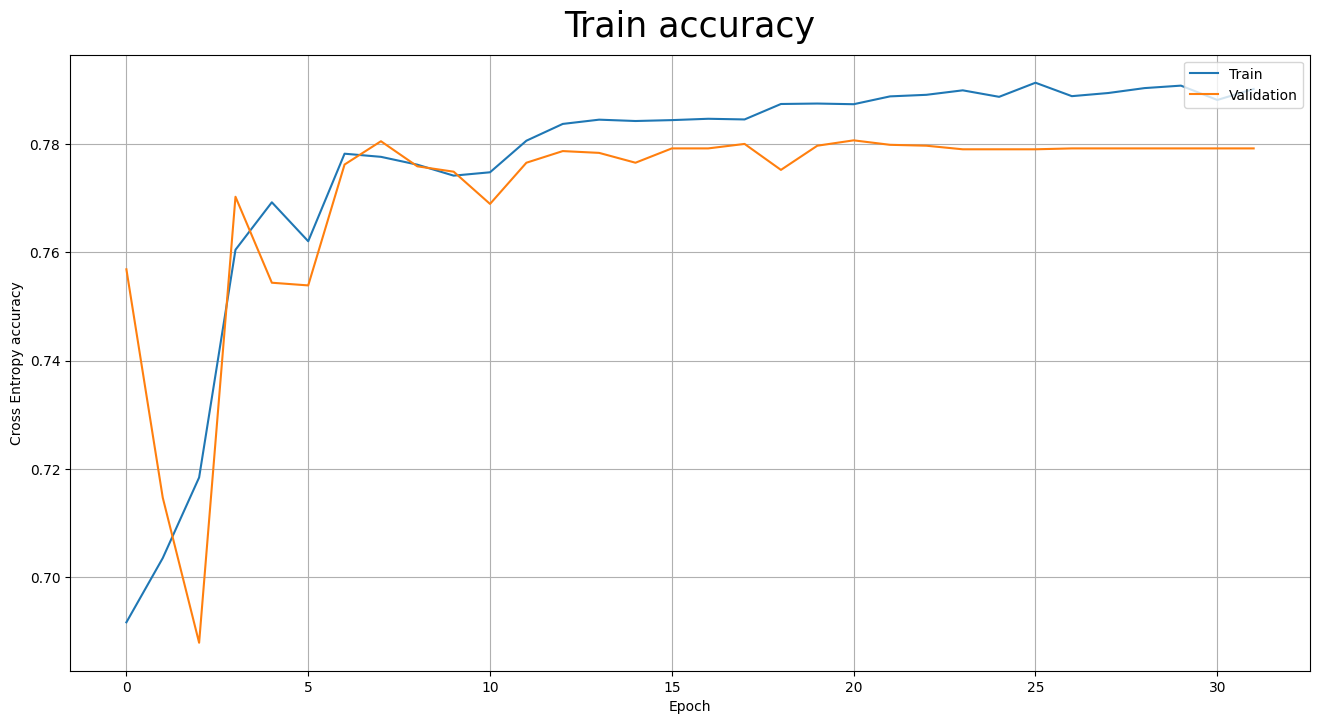

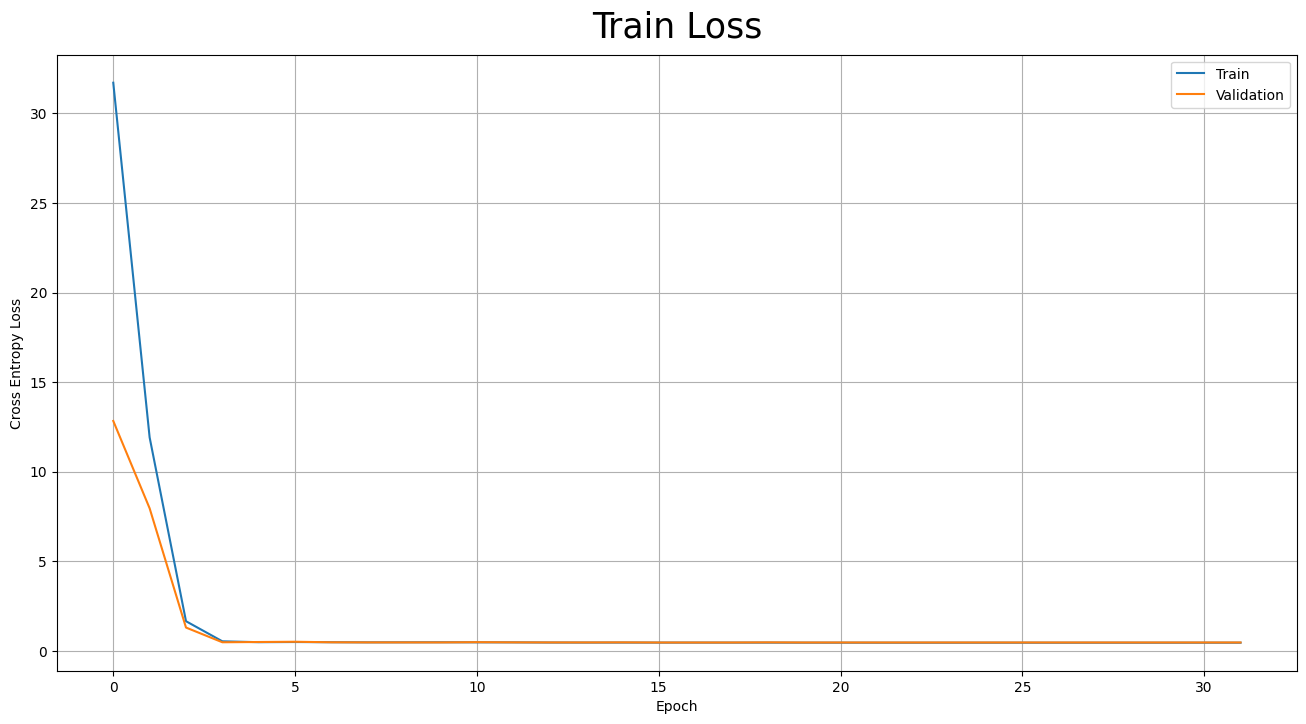

In [ ]:
plt.figure(figsize=(16, 8))

plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.ylabel('Cross Entropy accuracy')
plt.xlabel('Epoch')
plt.title('Train accuracy', pad=13, fontsize=25)
plt.legend(loc='upper right')
plt.grid(000.1)

plt.show()


plt.figure(figsize=(16, 8))

plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Epoch')
plt.title('Train Loss', pad=13, fontsize=25)
plt.legend(loc='upper right')
plt.grid(000.1)

plt.show()

In [ ]:
# Unfreeze base model for fine-tuning
base_model.trainable = True
for layer in base_model.layers:
    if isinstance(layer, BatchNormalization):  # BatchNorm lawyer; Freeze
        layer.trainable = False

# Fine-Tuned Model Compile
model.compile(optimizer=AdamW(learning_rate=0.00001),
              loss=losses.categorical_crossentropy,
              metrics=['accuracy', f1_m])

# Fine-Tuning Training
history = model.fit(X_train,
                    y_train,
                    batch_size=16,
                    epochs=100,
                    validation_data=(X_test, y_test),
                    callbacks=[
                        EarlyStopping(monitor="val_loss", patience=15,
                                      restore_best_weights=True, mode='min'),
                        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min')
                    ]
                   )

# Fine-Tuned Model Evaluation
fcl_loss, fcl_accuracy, fcl_f1 = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', fcl_loss)
print('Test accuracy:', fcl_accuracy)
print('Test F1:', fcl_f1)

# Predictions & Classification Report
df = pd.DataFrame({"pred": np.argmax(model.predict(X_test), axis=1), "true": np.argmax(y_test, axis=1)})
print(classification_report(df["true"], df["pred"]))

Epoch 1/100
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 29s 15ms/step - accuracy: 0.7816 - f1_m: 0.7816 - loss: 0.4579 - val_accuracy: 0.7777 - val_f1_m: 0.7777 - val_loss: 0.4646 - learning_rate: 1.0000e-05
Epoch 2/100
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - accuracy: 0.7884 - f1_m: 0.7884 - loss: 0.4531 - val_accuracy: 0.7789 - val_f1_m: 0.7788 - val_loss: 0.4614 - learning_rate: 1.0000e-05
Epoch 3/100
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - accuracy: 0.7869 - f1_m: 0.7869 - loss: 0.4520 - val_accuracy: 0.7727 - val_f1_m: 0.7727 - val_loss: 0.4757 - learning_rate: 1.0000e-05
Epoch 4/100
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - accuracy: 0.7904 - f1_m: 0.7904 - loss: 0.4494 - val_accuracy: 0.7812 - val_f1_m: 0.7812 - val_loss: 0.4603 - learning_rate: 1.0000e-05
Epoch 5/100
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - accuracy: 0.7888 - f1_m: 0.7888 - loss: 0.4546 - val_accuracy: 0.7777 - val_f1_m: 0.7777 - val_loss: 0.4645 - learning_rate: 1.0000e-05
Epoch 6/100
1512/1512 ━━━

In [ ]:
drive_folder = "/content/drive/MyDrive/ResNet_rsna"
os.makedirs(drive_folder, exist_ok=True)


model_path_ft = "/content/resnet_pneumonia_finetuned.h5"
drive_path_ft = os.path.join(drive_folder, "resnet_pneumonia_finetuned.h5")

model.save(model_path_ft)
shutil.copy(model_path_ft, drive_path_ft)

'/content/drive/MyDrive/ResNet_rsna/resnet_pneumonia_finetuned.h5'

In [42]:
drive_path_ft = "/content/drive/MyDrive/ResNet_rsna/resnet_pneumonia_finetuned.h5"
model_ft = load_model(drive_path_ft)

In [43]:
dcm_dir = "/content/rsna_data/stage_2_train_images"
csv_path = "/content/rsna_data/stage_2_train_labels.csv"

df_labels = pd.read_csv(csv_path)

# ONly target = 1
df_pneumonia1 = df_labels[df_labels["Target"] == 1]
patient_ids1 = df_pneumonia1["patientId"].unique()[:10]
df_pneumonia1.head()

patientId      x      y  width  height  Target
4   00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1
5   00436515-870c-4b36-a041-de91049b9ab4  562.0  152.0  256.0   453.0       1
8   00704310-78a8-4b38-8475-49f4573b2dbb  323.0  577.0  160.0   104.0       1
9   00704310-78a8-4b38-8475-49f4573b2dbb  695.0  575.0  162.0   137.0       1
14  00aecb01-a116-45a2-956c-08d2fa55433f  288.0  322.0   94.0   135.0       1

In [44]:
# ONly target = 0
df_pneumonia0 = df_labels[df_labels["Target"] == 0]
patient_ids0 = df_pneumonia0["patientId"].unique()[:10]
df_pneumonia0.head()

patientId   x   y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6 NaN NaN    NaN     NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd NaN NaN    NaN     NaN       0
2  00322d4d-1c29-4943-afc9-b6754be640eb NaN NaN    NaN     NaN       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5 NaN NaN    NaN     NaN       0
6  00569f44-917d-4c86-a842-81832af98c30 NaN NaN    NaN     NaN       0

In [45]:
X_test_sample1 = X_test[df_labels[df_labels["patientId"].isin(patient_ids1)].index]

predictions1 = model_ft.predict(X_test_sample1)
pneumonia_probs1 = predictions1[:, 1]
prediction_dict1 = {patient_id: pneumonia_probs1[i] for i, patient_id in enumerate(patient_ids1)}

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [46]:
X_test_sample0 = X_test[df_labels[df_labels["patientId"].isin(patient_ids0)].index]

predictions0 = model_ft.predict(X_test_sample0)
pneumonia_probs0 = predictions0[:, 1]
prediction_dict0 = {patient_id: pneumonia_probs0[i] for i, patient_id in enumerate(patient_ids0)}

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [58]:
def visualize_classification(patient_id, dcm_dir, df_labels, predictions):
    import os
    import pydicom
    import matplotlib.pyplot as plt

    dcm_path = os.path.join(dcm_dir, f"{patient_id}.dcm")
    if not os.path.exists(dcm_path):
        print(f"{dcm_path} not found.")
        return

    dicom_data = pydicom.dcmread(dcm_path)
    image = dicom_data.pixel_array

    # True Label
    true_label_row = df_labels[df_labels["patientId"] == patient_id]

    if not true_label_row.empty:
        true_label = 1 if (true_label_row["Target"] == 1).any() else 0
        has_pneumonia = "Pneumonia" if true_label == 1 else "Normal"
        true_color = "red" if true_label == 1 else "blue"
    else:
        has_pneumonia = "Unknown"
        true_color = "black"

    # Model Prediction
    pred_prob = predictions.get(patient_id, None)
    if pred_prob is not None:
        pred_label = "Pneumonia" if pred_prob >= 0.35 else "Normal"
        pred_text = f"Prediction: {pred_label} ({pred_prob:.2f})"
        pred_color = "red" if pred_label == "Pneumonia" else "blue"
    else:
        pred_text = "Prediction: Normal (x)"
        pred_color = "blue"

    # Print image
    plt.figure(figsize=(6, 6))
    plt.imshow(image, cmap="gray")
    plt.axis("off")

    # True Label과 Prediction with different colors
    plt.text(0.5, 1.05, f"True Label: {has_pneumonia}", fontsize=14, color=true_color, ha="center", transform=plt.gca().transAxes)
    plt.text(0.5, 1.02, pred_text, fontsize=14, color=pred_color, ha="center", transform=plt.gca().transAxes)

    plt.show()


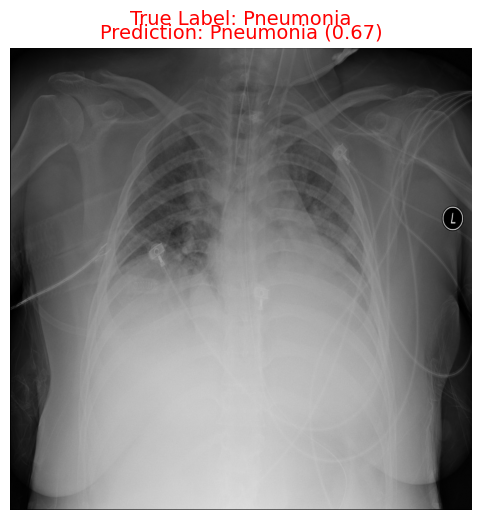

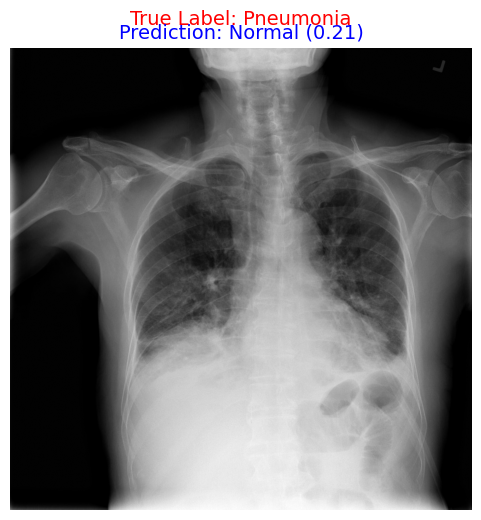

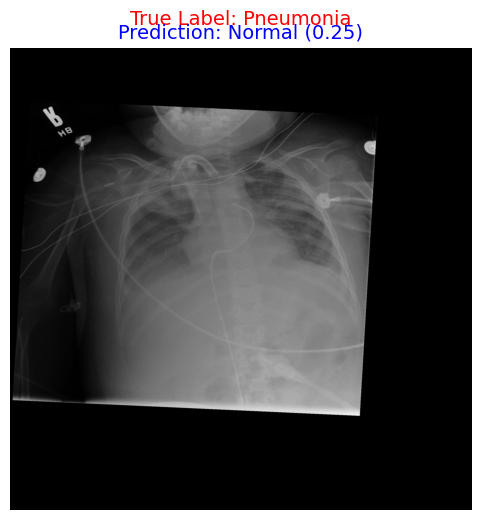

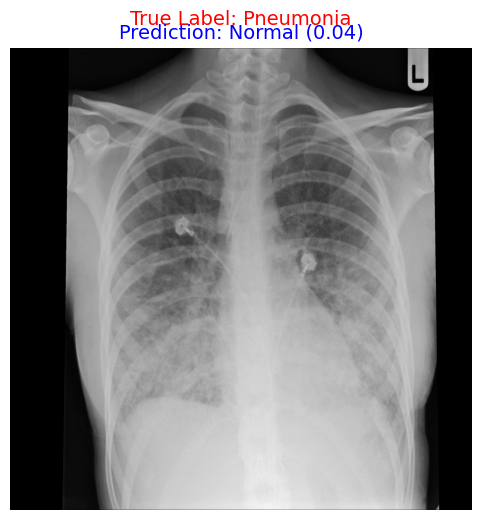

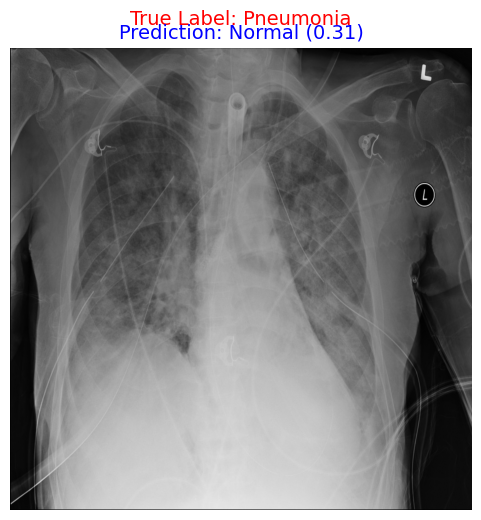

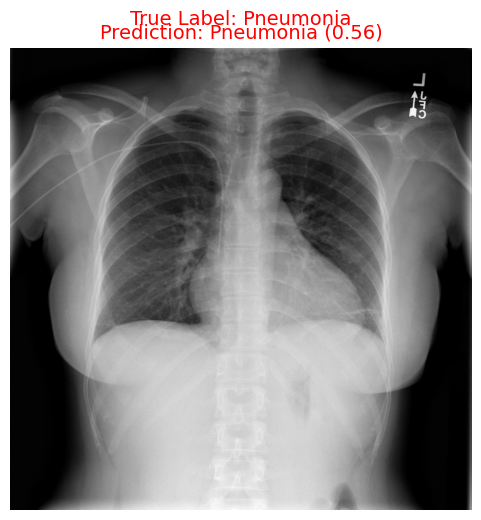

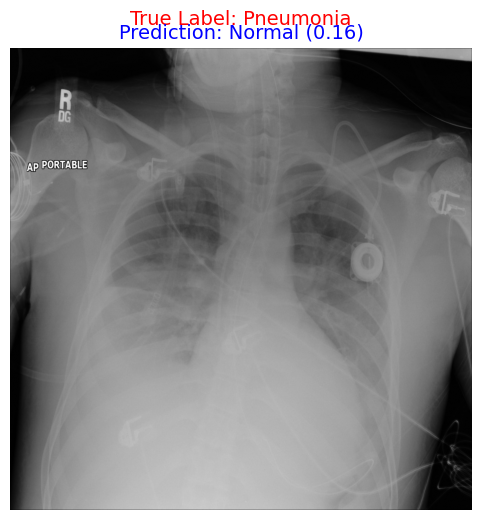

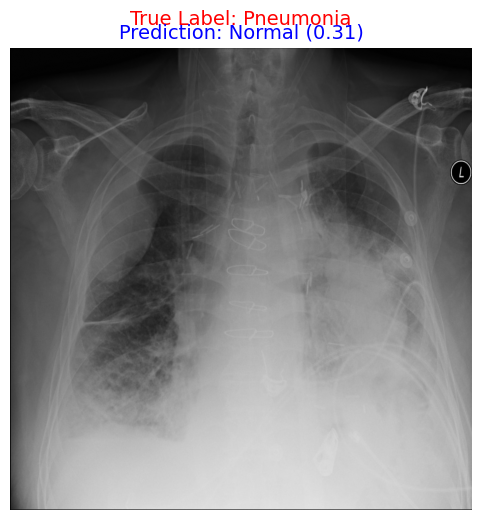

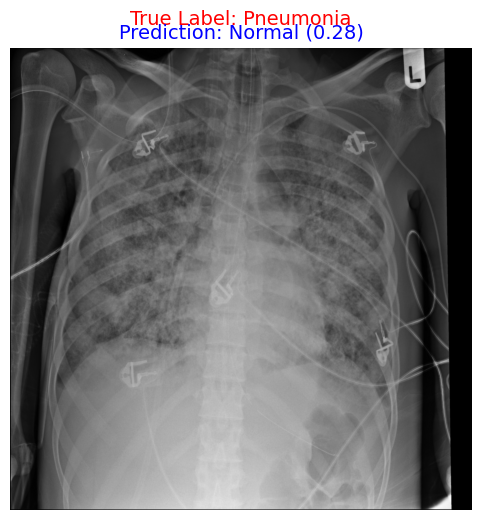

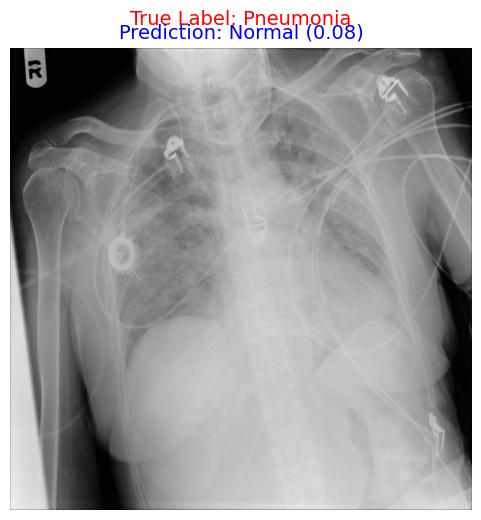

In [59]:
for patient_id in patient_ids1:
    visualize_classification(patient_id, dcm_dir, df_pneumonia1, prediction_dict1)

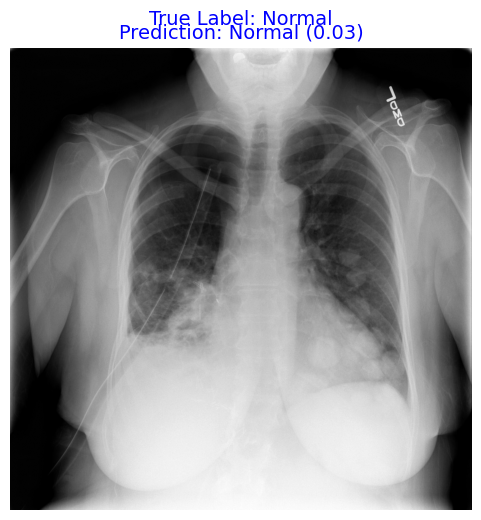

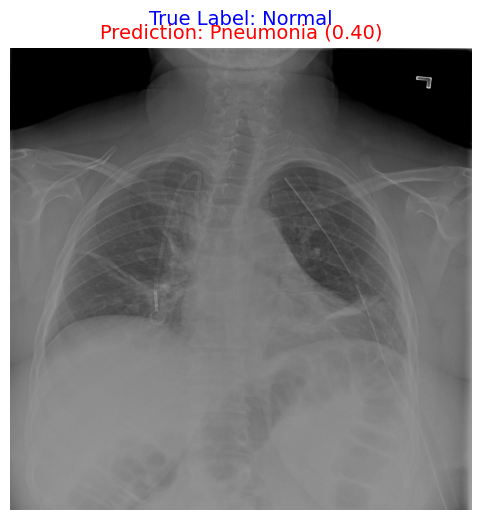

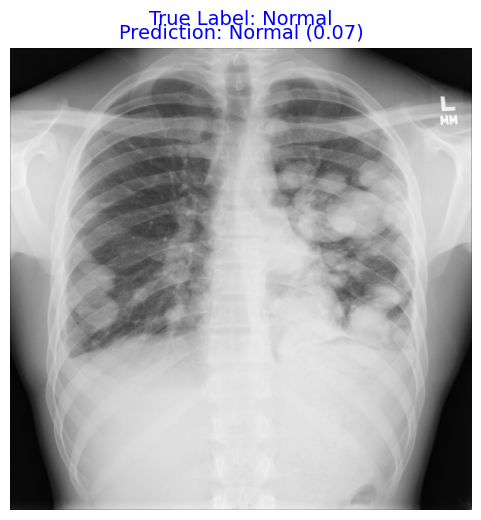

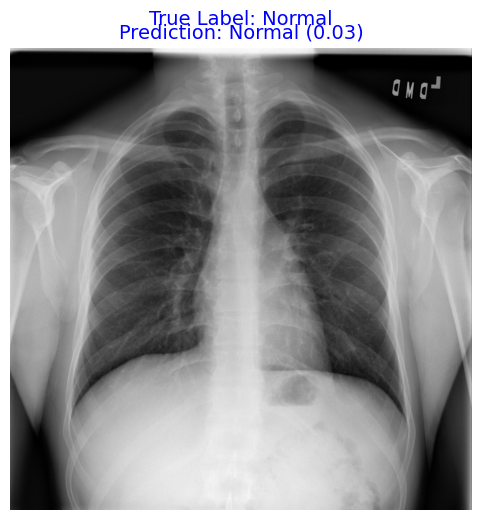

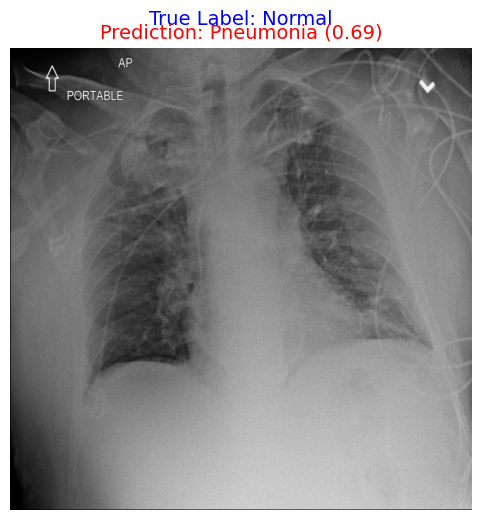

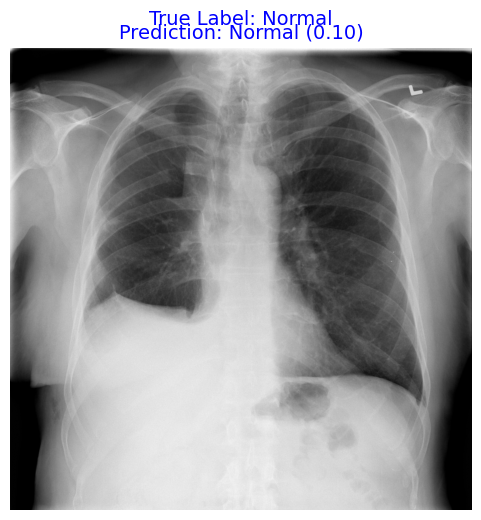

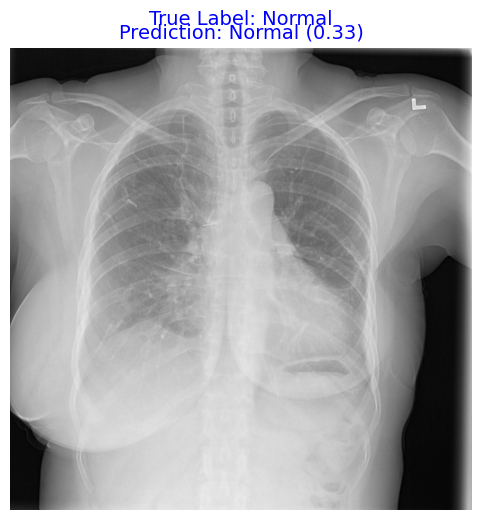

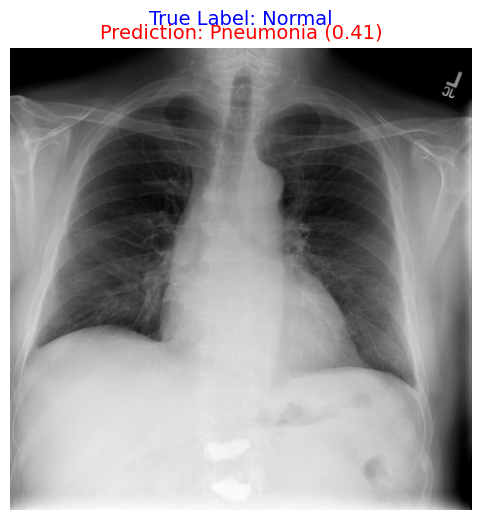

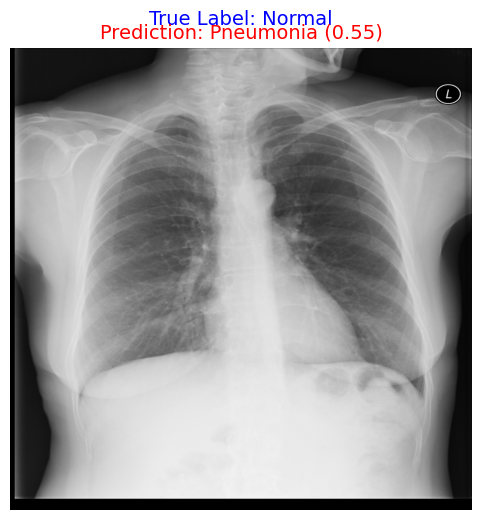

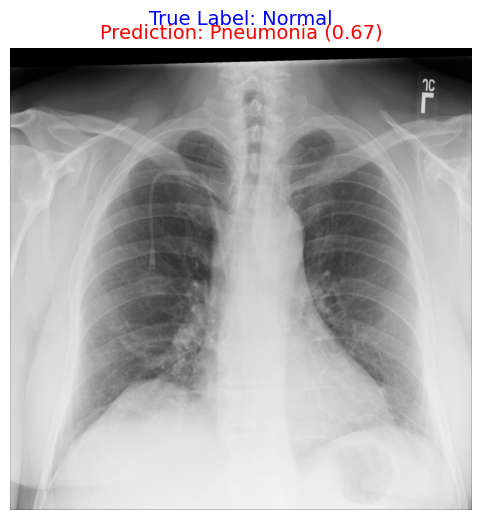

In [60]:
for patient_id in patient_ids0:
    visualize_classification(patient_id, dcm_dir, df_pneumonia0, prediction_dict0)

In [34]:
print(df_labels.dtypes)
print(df_labels.head())

patientId     object
x            float64
y            float64
width        float64
height       float64
Target         int64
dtype: object
                              patientId      x      y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1


In [35]:
print(f"Patient ID {patient_id} exists in df_labels:", patient_id in df_labels["patientId"].values)

Patient ID 019d950b-dd38-4cf3-a686-527a75728be6 exists in df_labels: True


In [41]:
true_label_row = df_labels[df_labels["patientId"] == patient_id]
print(true_label_row)

                               patientId      x      y  width  height  Target
36  019d950b-dd38-4cf3-a686-527a75728be6  229.0  318.0  250.0   301.0       1
37  019d950b-dd38-4cf3-a686-527a75728be6  604.0  216.0  196.0   328.0       1
